# 🥾 Lecture 5 Lab: The Bootstrap

<img src="img/bootstraps.jpeg" alt= “bootstraps” width="350" /> <img src="img/bootstrap-cartoon.jpeg" alt= “bootstrap-cartoon” width="300" />

## ✅ Setup and data import
In this lab, we will work with salary data from 2022 for employees of the state of California. 
The data [are](https://digitalblog.ons.gov.uk/2016/12/08/data-is-versus-data-are/#:~:text=The%20grammatically%20correct%20approach%20is,the%20latin%20word%20'datum'.) provided by [Transparent California](https://transparentcalifornia.com/).

In [80]:
# Load in additional functions
library(tidyverse)
library(lubridate)

# Use three digits past the decimal point
options(digits = 3)

# Format plots with a white background and dark features.
theme_set(theme_bw())

# Increase the default text size of plots.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
theme_update(text = element_text(size = 20))

# Increase the default plot width and height.
# If you are *not* working in Google Colab, we recommend commenting
# out this line of code.
options(repr.plot.width=12, repr.plot.height=8)

salaries = read_csv("https://jdgrossman.com/assets/california-salaries-2022.csv")

# peek at 10 random rows
sample_n(salaries, 10)

Rows: 261556 Columns: 2
── Column specification ───────────────────────────────────────────────
Delimiter: ","
chr (1): title
dbl (1): pay

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


title,pay
<chr>,<dbl>
Correctional Sergeant,112018
Staff Services Manager Ii (Managerial),102411
"Dentist, Correctional Facility",239099
Correctional Officer,106593
"Member Helper V, Veterans Home/Department Of Veterans Affairs",4800
Correctional Officer,3027
Associate Governmental Program Analyst,82180
Manager I Department Of Motor Vehicles,32789
Caltrans Highway Maintenance Worker,3673


### ♨️ Warm up

How many individuals are in the dataset? Compute the mean, median, and 90th percentile salary among California employees in 2022. Which job(s) have the lowest pay? Which have the highest pay?

In [81]:
# Your code here!

# START solution

# About 262k California employees
nrow(salaries)

# 84k mean, 79k median, 150k 90th percentile
salaries %>% 
  summarize(mean(pay),
            median(pay),
            quantile(pay, probs=0.9)
           )

# One way to get max pay. 
salaries %>%
  filter(pay == max(pay))

# Another method. Arrange in descending order by pay and pick out the first row.
salaries %>%
  arrange(desc(pay)) %>%
  slice(1)
 
# The lowest paying job has a negative salary? Probably not. For a more
# rigorous analysis, we would probably fix or remove rows like this.
salaries %>%
  arrange(pay) %>%
  slice(1)

# END solution

[1] 261556

mean(pay),median(pay),"quantile(pay, probs = 0.9)"
<dbl>,<dbl>,<dbl>
84177,78564,149956


title,pay
<chr>,<dbl>
"Chief Investment Officer, California State Teachers' Retirement System",1683398


title,pay
<chr>,<dbl>
"Chief Investment Officer, California State Teachers' Retirement System",1683398


title,pay
<chr>,<dbl>
E4,-86


## 💰 A random sample of salaries

Above, we calculated population-level statistics for salary data. No inference required! 

However, suppose the state of California did not publicly report salaries for all 262k state employees. 

Instead, suppose all we could get is a random sample of 500 salaries. Using these 500 salaries, can we say something meaningful about the salaries of all California employees?

In [82]:
n = 500

sample_pay = sample(salaries$pay, size=500, replace=FALSE) 

head(sample_pay)

[1] 159013  72660  28701 115491 165667 145947

🚀 **Exercise**: The formula for the estimated standard error of a population proportion, which we derived last week, is below. Using the formula, construct an 80% confidence interval for the proportion of California employees with salaries over \\$100,000. Does your interval contain the actual fraction of salaries above \\$100,000? If yes, is the actual fraction of salaries near the middle of your interval? Re-run the sampling a couple times to see how often your interval does or does not contain the estimand.

$$\hat{{\text{se}}}({\hat{p}}) = \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$$

In [83]:
# Your code here!

# START answer

p_hat = mean(sample_pay >= 100000)
moe = qnorm(0.9)*sqrt(p_hat*(1-p_hat)/length(sample_pay))

print('Confidence interval:')
print(c(p_hat - moe, p_hat + moe))

print('True proportion of salaries over 100,000')
mean(salaries$pay >= 100000)

# END answer

[1] "Confidence interval:"
[1] 0.332 0.388
[1] "True proportion of salaries over 100,000"


[1] 0.336

## 🤔 Inference with statistics other than proportions and averages

The closed-form expression (i.e., formula) for the standard error of a proportion performs relatively well, as we saw above. 

But, we cannot easily calculate closed-form expressions for every estimator.

For example, how would we go about calculating the standard error of the 90th percentile of a distribution? It's not so simple! 

For more complex estimators, our best solution is **the bootstrap**.

## 🥜 The boostrap, in a nutshell

An alternative approach to calculating the standard error analytically: we could (1) take multiple samples of salaries ("parallel universes"), (2) calculate an estimate of the 90th percentile salary in each sample, and (3) compute the standard deviation of the estimates across parallel universes. This process would provide a nice approximation of the true standard error. 

The problem: parallel universes aren't easily accessible. We usually get one shot at sampling.

A side door solution: if we are willing to assume that our sample is sufficiently representative of the population, we could randomly draw **new, synthetic samples** from our real sample. In this way, we can construct synthetic parallel universes. **This is the core idea of the bootstrap.**

<img src="img/bootstrap-overview.png" alt= “bootstrap-overview” width="600" />

## 👢 Bootstrap sampling

We can create synthetic parallel universes by **resampling from our observed data with replacement**, and then computing our estimate using new, synthetic samples.

The bootstrap resampling process for the 90th percentile estimator is below. 

1. Draw $X_1^*,\dots,X_{500}^* \sim \hat{F}_{500}$ 
2. Compute $\hat{\theta}_{500}^* = q_{90}(X_1^*,\dots,X_{500}^*)$

> $\hat{\text{F}}_n$ is known as the **empirical distribution function** for a sample size of $n$. $\hat{\text{F}}_n$ assigns mass $1/\text{n}$ to each sample observation. 
>
> $q_{90}$ is a function that returns the 90th percentile of its input.
>
> A star$^*$ next to a term implies that it's a synthetic term. In other words, it's not from a real sample or an estimate based on a real sample.

Think of the resampling process like putting all $n$ real observations from our sample in a bag, and then randomly drawing $n$ observations from the bag. After we draw each observation, we put it back, so the same observation can be drawn multiple times.

<img src="img/resampling.png" alt= “bootstrap-resampling” width="600" />

Let's try this in `R`!

🚀 **Exercise**: Generate a single bootstrap sample from our sample of 500 salaries. Calculate the 90th percentile of the bootstrap sample.

Bonus: Write an `R` function `get_boot_90` to generate a bootstrapped 90th percentile from a input sample.

Some things to keep in mind:

- The `sample` command may come in handy. See `?sample`.
- How many observations should we resample from our 500 salaries?
- Why do we need to sample with replacement?

In [84]:
# Your code here!

# START solution

# We want to replicate the features of our estimator.
# The size of our sample is a critical feature of the estimator.
# So, we should sample 500 times with replacement.

# generate one bootstrap sample
n = length(sample_pay)
boot_sample = sample(sample_pay, n, replace = TRUE)
print("One bootstrap sample:")
print(head(boot_sample))

# find 90th percentile of bootstrap sample
print("90th percentile of one bootstrap sample:")
print(quantile(boot_sample, probs=0.9))

# For convenience, we can functionalize this process.
get_boot_90 = function(input_sample) {
    n = length(input_sample)
    boot_sample = sample(input_sample, n, replace = TRUE)
    
    q_90_star = quantile(boot_sample, 0.9)
  
    # the last line of an R function is automatically returned
    q_90_star
}

print("Bootstrapped 90th percentiles:")
print(get_boot_90(sample_pay))
print(get_boot_90(sample_pay))
print(get_boot_90(sample_pay))

# END solution

[1] "One bootstrap sample:"
[1] 138342 132770  72966 105416  56761  58246
[1] "90th percentile of one bootstrap sample:"
   90% 
153363 
[1] "Bootstrapped 90th percentiles:"
   90% 
145626 
   90% 
149244 
   90% 
154822 


## 🔔 Bootstrapped sampling distribution

We can repeat the process above many times to approximate the sampling distribution of the estimator for the 90th percentile salary.

Note that we **only use the bootstrapped sampling distribution to calculate the standard error** of our estimator, not its expected value! 

Our best guess of the expected value is the 90th percentile of the **original** sample of 500 salaries.

🚀 **Exercise**:

Generate `B` bootstrap samples, and calculate the 90th percentile of each sample. Using your `B` bootstrapped estimates of the 90th percentile of salaries, calculate the estimated standard error of our estimator of the 90th percentile, and construct a confidence interval using the normal approximation. 

Some things to keep in mind:

- The `replicate` command may come in handy.
- How many bootstrap samples should we generate? In other words, what's a good value of `B`?
- What should be the point estimate of our confidence interval?
- Is the normal approximation reasonable?


[1] "Standard deviation of bootstrapped 90th percentiles:"
[1] 3754
[1] "Bootstrapped confidence interval of the 90th percentile income: "
   90%    90% 
141886 156603 
[1] "True 90th percentile of salaries:"


90% 
149956

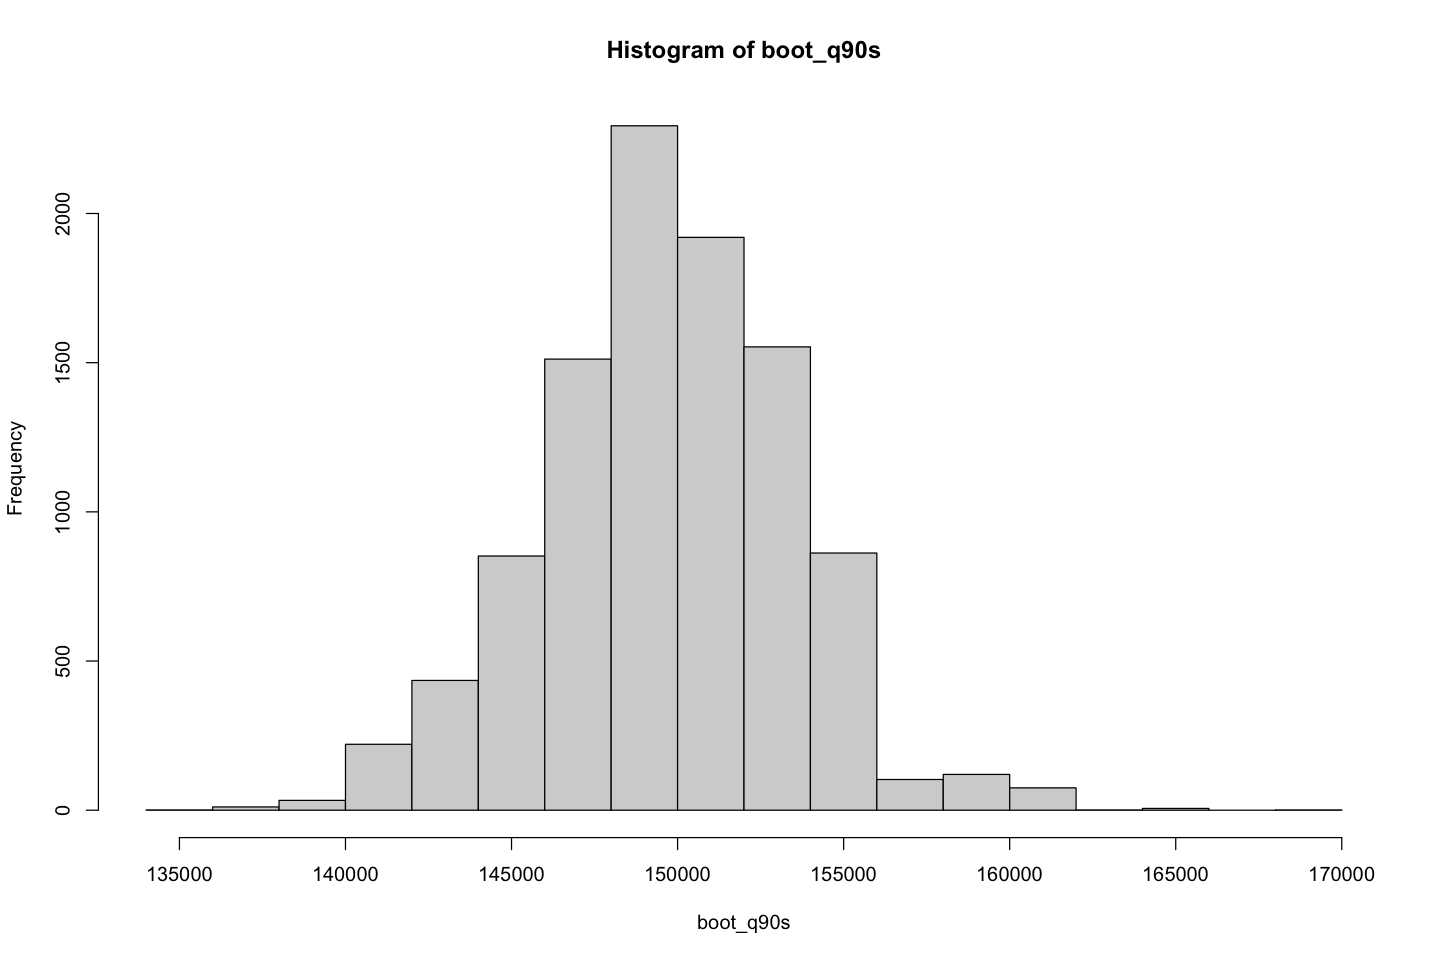

In [87]:
# Your code here!

# START solution

# B is chosen by balancing the computational power available to you, 
# and whether adding more replications makes a difference, numerically.
# 10,000 is usually a good choice, but feel free to modify and explore. 

B = 10000
boot_q90s = replicate(B, get_boot_90(sample_pay))

# Standard error of bootstrapped 90th percentiles
se_boot = sd(boot_q90s)
print("Standard deviation of bootstrapped 90th percentiles:")
print(se_boot)

# The point estimate of our CI should be computed from the original data.
# The bootstrap samples are only used to compute the standard error of the estimator!
point_estimate = quantile(sample_pay, 0.9)
moe = qnorm(0.975)*se_boot

# Confidence interval
ci_boot = c(point_estimate - moe, point_estimate + moe)
print("Bootstrapped confidence interval of the 90th percentile income: ")
print(ci_boot)

# Is true 90th percentile salary in our interval? 
print('True 90th percentile of salaries:')
quantile(salaries$pay, 0.9)

# bootstrapped sampling distribution looks pretty normal
hist(boot_q90s)

# END solution

## 🩰 Percentile and pivotal intervals

Computing confidence intervals with the normal approximation assumes that the sampling distribution is normal. 

What if we aren't confident in this assumption? 

We can report the $\alpha/2$ and $1-\alpha/2$ percentiles of the bootstrapped sampling distribution. 

We can also use the pivotal method, which is a technically more accurate method:
$\left(2 \hat{\theta} - \hat{\theta}^*_{1-\alpha/2}, 2 \hat{\theta} - \hat{\theta}^*_{\alpha/2}\right)$

> Note that the percentile and pivotal methods still assume that the bootstrapped sampling distribution is a good approximation of the true sampling distribution. The sampling distribution just doesn't have to be normal!

🚀 **Exercise**:

Compute the 95% percentile and pivotal intervals of the 90th percentile salary. 

In [86]:
# Your code here!

# START solution

theta_hat = quantile(sample_pay, 0.9)
theta_hat_star_lower = quantile(boot_q90s, 0.025, names=FALSE)
theta_hat_star_upper = quantile(boot_q90s, 0.975, names=FALSE)

print('Percentile interval:')
print(c(theta_hat_star_lower, theta_hat_star_upper))

print('Pivotal interval:')
ci_pivotal = 2 * theta_hat - c(theta_hat_star_upper, theta_hat_star_lower)
print(ci_pivotal)

# END solution

[1] "Percentile interval:"
[1] 142091 156903
[1] "Pivotal interval:"
[1] 141586 156398
